In [ ]:
"""
conditional GAN - pix2pix GAN model
""" 

In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Dataset 불러오기: facade dataset
#!git clone https://github.com/mrzhu-cool/pix2pix-pytorch.git

In [4]:
# Custom dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

In [5]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(), # augmentaion 하지 않음
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

In [6]:
#데이터셋 경로 불러오기
path2img = r'C:\Users\10\OneDrive\바탕 화면\pytorch_condtional_gan\facades\facades\train' # r : 한글경로
train_ds = FacadeDataset(path2img, transform=transform)

(-0.5, 255.5, 255.5, -0.5)

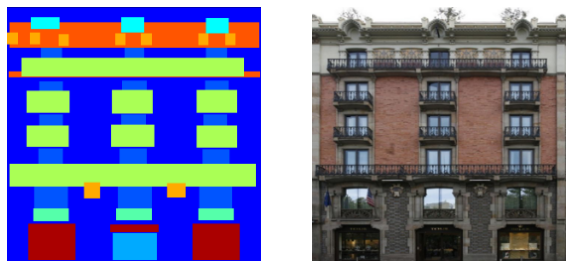

In [7]:
# 샘플 이미지 확인하기
a,b = train_ds[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [8]:
#데이터로더 불러오기
# cuda 문제 발생시, batch_size=32 줄이기
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [9]:
#Generator 모델 생성
class UNetDown(nn.Module): # 좌측 : 차원축소
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels, out_channels, 4 ,stride=2, padding=1, bias=False)]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),
            
        layers.append(nn.LeakyReLU(0,2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.down = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.down(x)
        return x
    
#model check    
x = torch.randn(16, 3, 256, 256, device=device)
model = UNetDown(3, 64).to(device)
down_out = model(x)
print(down_out.shape)

torch.Size([16, 64, 128, 128])


In [10]:
class UNetUp(nn.Module): # 우축
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=True),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.up = nn.Sequential(*layers)
        
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), 1)
        return x
#model check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128, 64).to(device)
out = model(x, down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


In [11]:
#pix2pix에 사용되는 실제 generator 구성
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256, dropout=0.5)
        self.up6 = UNetUp(512, 128, dropout=0.5)
        self.up7 = UNetUp(256, 64, dropout=0.5)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x): # 순전파를 넘겨주기 위한 함수
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7) # UNet 우측에 순전파로 넘어가는 과정
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.up8(u7)

        return u8 # 최종 output

# model test
x = torch.randn(16, 3, 256, 256, device=device)
model_gen = GeneratorUNet().to(device)
out = model_gen(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


- patch gan : https://brstar96.github.io/mldlstudy/what-is-patchgan-D/
- Unet 논문 리뷰 : https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a

In [12]:
# discriminator model(patch GAN 사용)
# patch gan: 입력 이미지를 여러개로 분할하여, 분할된 부분이 가짜 or 진짜인지 식별하는 모델
class Dis_block(nn.Module):
    
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize: # normalize = True이면
            layers.append(nn.InstanceNorm2d(out_channels))
        
        layers.append(nn.LeakyReLU(0.2))
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x): # 순전파 넘겨주는 과정
        x = self.block(x)
        
        return x
    
# model test
x = torch.randn(16, 64, 256, 256, device=device)
model = Dis_block(64, 128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 128, 128])


In [13]:
# pix2pix에 사용되는 실제 diescriminator 구성
class Discriminator(nn.Module): # classification을 하는 역할
    def __init__(self, in_channels=3):
        super().__init__()
        
        self.stage_1 = Dis_block(in_channels*2, 64, normalize=False)
        self.stage_2 = Dis_block(64, 128)
        self.stage_3 = Dis_block(128, 256)
        self.stage_4 = Dis_block(256, 512)
        
        self.patch = nn.Conv2d(512, 1, 3, padding=1)
        
    def forward(self, a, b):
        x = torch.cat((a, b), 1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        
        return x
    
# model test
x = torch.randn(16, 3, 256, 256, device=device)
model_dis = Discriminator().to(device)
out = model_dis(x, x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [14]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1: # Convolutional 레이어에서만 초기화 시행
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (stage_1): Dis_block(
    (block): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_2): Dis_block(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_3): Dis_block(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (stage_4): Dis_block(
    (block): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slo

In [15]:
# 학습에 필요한 하이퍼 파라미터 선언

# 손실함수(loss fuction)
loss_func_gan = nn.BCELoss() # genraotor
loss_func_pix = nn.L1Loss() # pix2pix

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1, 256//2**4, 256//2**4)

# 최적화에 사용되는 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_gen = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))

In [20]:
# 학습 진행
model_gen.train()
model_dis.train()

batch_count = 0 # for 문 증가시키기 위한 초기값
num_epochs = 100 # range할만큼
start_time = time.time() # 현재시간을 기록 # 몇초가 걸린지

loss_hist = {'gen' : [],
            'dis' : []} # 리스트 배열 초기화

for epoch in range(num_epochs):
    for a, b in train_dl: # 데이터로부터 데이터를 불러오고
        ba_si = a.size(0)
        
        # real image
        real_a = a.to(device)
        real_b = b.to(device)
        
        # patch_label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)
        
        # generator
        model_gen.zero_grad()
        
        fake_b = model_gen(real_a) # 가짜이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별
        
        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)
        
        g_loss = gen_loss + lambda_pixel * pixel_loss # loss는 application에 맞게 선언함
        g_loss.backward()
        opt_gen.step()
        
        # discriminator
        model_dis.zero_grad()
        
        out_dis = model_dis(real_b, real_a) # 진짜 이미지에 대한 식별
        real_loss = loss_func_gan(out_dis, real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지에 대한 식별
        fake_loss = loss_func_gan(out_dis, fake_label)
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_dis.step()
        
        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())
        
        batch_count += 1
        if batch_count % 100 == 0:
            print("Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min"
                 % (epoch, g_loss.item(), d_loss.item(), (time.time()-start_time/60)))

Epoch: 7, G_Loss: 43.966061, D_Loss: 0.000017, time: 1617999993.18 min
Epoch: 15, G_Loss: 45.378567, D_Loss: 0.000016, time: 1618000030.38 min
Epoch: 23, G_Loss: 43.047089, D_Loss: 0.000014, time: 1618000067.38 min
Epoch: 30, G_Loss: 45.642963, D_Loss: 0.000013, time: 1618000105.45 min
Epoch: 38, G_Loss: 43.728306, D_Loss: 0.000013, time: 1618000144.30 min
Epoch: 46, G_Loss: 44.929245, D_Loss: 0.000013, time: 1618000183.07 min
Epoch: 53, G_Loss: 46.106674, D_Loss: 0.000011, time: 1618000222.47 min
Epoch: 61, G_Loss: 47.166473, D_Loss: 0.000011, time: 1618000261.29 min
Epoch: 69, G_Loss: 43.833027, D_Loss: 0.000011, time: 1618000300.14 min
Epoch: 76, G_Loss: 43.347790, D_Loss: 0.000010, time: 1618000339.92 min
Epoch: 84, G_Loss: 43.710915, D_Loss: 0.000010, time: 1618000379.00 min
Epoch: 92, G_Loss: 45.992233, D_Loss: 0.000009, time: 1618000418.13 min
Epoch: 99, G_Loss: 46.544903, D_Loss: 0.000008, time: 1618000457.42 min


In [21]:
# Epoch: 99, G_Loss: 45.843269, D_Loss: 0.000212, time: 1617997720.89 min

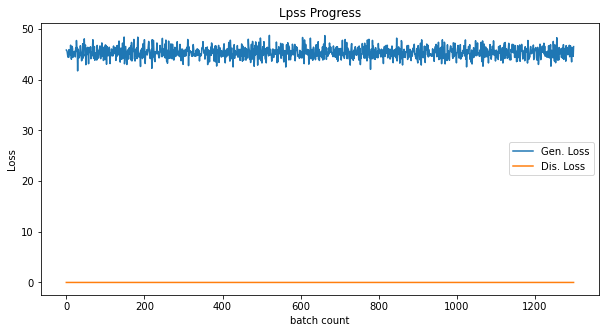

In [22]:
# matplotlib을 사용한 loss history 시각화
plt.figure(figsize=(10,5))
plt.title('Lpss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show() # gen : 점차 떨어지는 # dis: 거의 변화 없음

In [23]:
# 가중치 저장하기
path2models = "./models/"
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [24]:
# Generator가 생성한 가짜 이미지 확인하기

# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dictd_state_dict(weights)

<All keys matched successfully>

In [25]:
# 가짜 이미지 생성하기
model_gen.eval()

with torch.no_grad():
    for a, b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

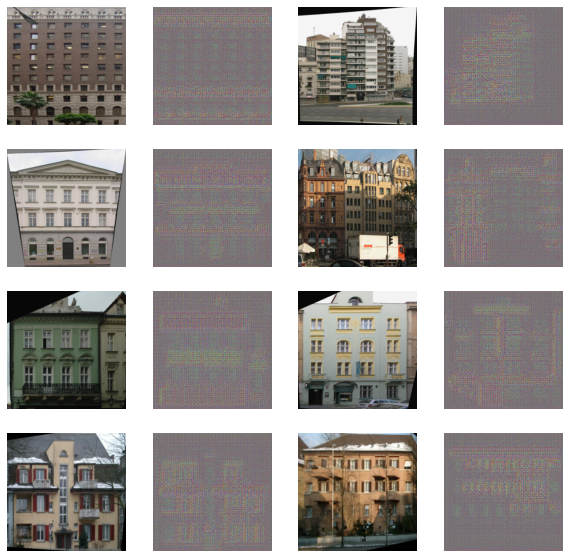

In [26]:
# 가짜 이미지 시각화 하기
# 실제, fake
plt.figure(figsize=(10, 10))

for ii in range(0, 16, 2):
    plt.subplot(4, 4, ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4, 4, ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')

In [ ]:
# epoch을 더 높인다면 더 나음